In [1]:
# Common imports
import utils
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Preprocessing
from transformer import DataFrameSelector
from transformer import DiscountConverter
from transformer import DateToWeekConverter
from transformer import CategoryConverter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Oversampling
from imblearn.over_sampling import SMOTE

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Create stratified train and validation sets
from sklearn.model_selection import StratifiedShuffleSplit

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

# Deep Learning model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

## Acquire data

In [2]:
train = utils.load_data('ccf_offline_stage1_train.csv')
test = utils.load_data('ccf_offline_stage1_test_revised.csv') 

In [3]:
train.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN
5,1439408,2632,NaN,NaN,0.0,NaN,20160516.0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0
7,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
8,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
9,2029232,450,1532.0,30:5,0.0,20160530.0,NaN


In [4]:
train['Date_received'] =  pd.to_datetime(train['Date_received'], format='%Y%m%d')
test['Date_received'] =  pd.to_datetime(test['Date_received'], format='%Y%m%d')
train['Date'] =  pd.to_datetime(train['Date'], format='%Y%m%d')

## Make labels

In [5]:
train['label'] = 1
train.loc[train['Date'].isnull() | train['Coupon_id'].isnull(), 'label'] = 0
train.loc[(train['Date'] - train['Date_received']).dt.days > 15, 'label'] = 0

In [6]:
train.loc[train['label'] == 1].head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label
33,1113008,1361,11166.0,20:1,0.0,2016-05-15,2016-05-21,1
38,2881376,8390,7531.0,20:5,0.0,2016-03-21,2016-03-29,1
69,114747,6901,2366.0,30:5,0.0,2016-05-23,2016-06-05,1
76,114747,5341,111.0,30:5,0.0,2016-02-07,2016-02-18,1
77,114747,5341,7751.0,50:10,0.0,2016-01-27,2016-01-28,1


In [7]:
train.loc[train['label'] == 1].count()

User_id          64395
Merchant_id      64395
Coupon_id        64395
Discount_rate    64395
Distance         57060
Date_received    64395
Date             64395
label            64395
dtype: int64

In [8]:
train.loc[train['label'] == 0].count()

User_id          1690489
Merchant_id      1690489
Coupon_id         988887
Discount_rate     988887
Distance         1591821
Date_received     988887
Date              712589
label            1690489
dtype: int64

**The classes are extremely imbalanced. Possibly needs oversampling**

In [9]:
print('The ratio of class 1 and class 0 is', 64395 / 1690489)

The ratio of class 1 and class 0 is 0.038092528256616874


## Split training set to training and validation set

In [10]:
train_copy = train.copy()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in split.split(train_copy, train_copy['label']):
    train = train_copy.loc[train_index]
    validation = train_copy.loc[val_index]

## Build custom transformers for data preprocessing pipelines

**Convert "Date_received" to weekdays, and then to onehot matrix.**

In [11]:
date_pipeline = Pipeline([
    ('selector', DataFrameSelector(attribute_names=['Date_received'])),
    ('week_converter', DateToWeekConverter()),
    ('one_hot', OneHotEncoder(categories="auto")),
])


**Fill NA with 0 in "Discount_rate" feature,  make elements in the same format, and scale them.**

In [12]:
discount_pipeline = Pipeline([
    ('selector', DataFrameSelector(attribute_names=['Discount_rate'])),
    ('discount_converter', DiscountConverter()),
    ('std_scaler', StandardScaler()),
])

**Categorize "Merchant_id" feature into onehot matrix**

In [13]:
Merchant_pipeline = Pipeline([
    ('selector', DataFrameSelector(attribute_names=['Merchant_id'])),
    ('Category_converter', CategoryConverter(scale=1800)),
    ('one_hot', OneHotEncoder(categories="auto")),
])

**Scale "Distance" feature"**

In [14]:
distance_pipeline = Pipeline([
    ('selector', DataFrameSelector(attribute_names=['Distance'])),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

**Combine different preprocessing pipelines**

In [15]:
full_pipeline = FeatureUnion(transformer_list=[
    ("date_pipeline", date_pipeline),
    ("discount_pipeline", discount_pipeline),
    ("merchant_pipeline", Merchant_pipeline),
    ("distance_pipeline", distance_pipeline),
])

In [16]:
y_train = train["label"].values
X_train = full_pipeline.fit_transform(train)

y_val = validation["label"].values
X_val = full_pipeline.transform(validation)

**Oversampling with SMOTE method**

In [17]:
Counter(y_train)

Counter({0: 1352391, 1: 51516})

In [18]:
sm = SMOTE(random_state=42, sampling_strategy=0.25)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [19]:
Counter(y_train)

Counter({0: 1352391, 1: 338097})

## Select and train a model
**Linear Regression--Underfitting**

In [20]:
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

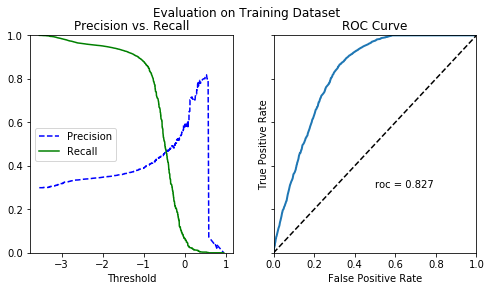

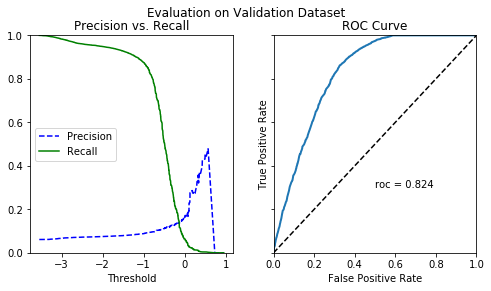

In [21]:
utils.evaluate_model(log_reg, X_train, y_train, X_val, y_val, plot_train=True, model_type='sklearn_regressor')

**Random Forest**

In [22]:
for_cls = RandomForestClassifier(n_estimators=100)
for_cls.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

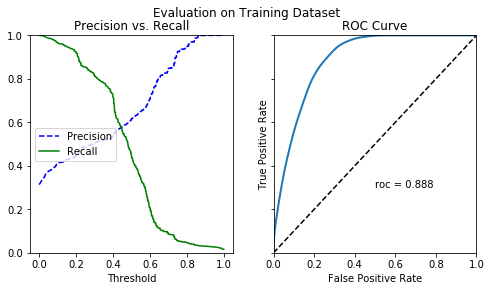

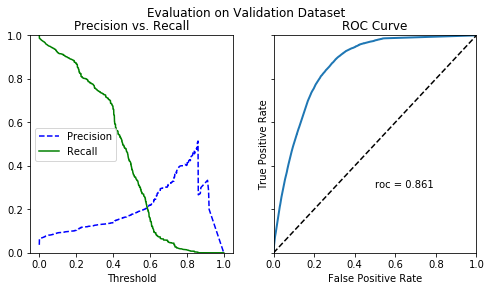

In [23]:
utils.evaluate_model(for_cls, X_train, y_train, X_val, y_val, plot_train=True, model_type='sklearn_classifier')

**XGBoost**

In [24]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 20,
    'min_child_weight': 2,
    'learning_rate': 0.1,
    'silent': True,
    'n_estimater': 500,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'scale_pos_weight': 1,
}

In [25]:
xgb_cls = XGBClassifier(**params)
xgb_cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=20, min_child_weight=2, missing=None,
       n_estimater=500, n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

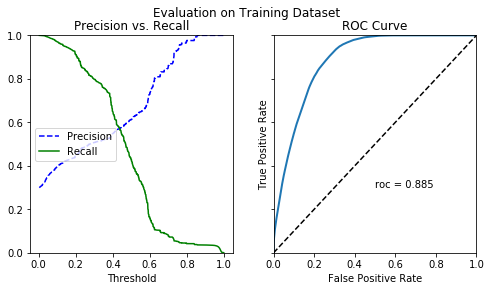

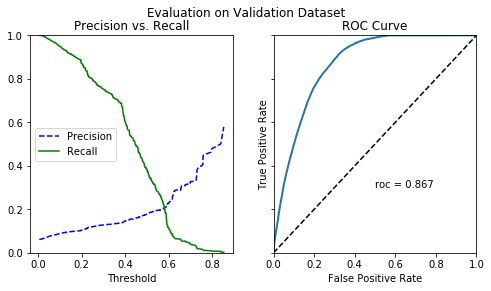

In [26]:
utils.evaluate_model(xgb_cls, X_train, y_train, X_val, y_val, plot_train=True, model_type='sklearn_classifier')

**Keras Neural Network**

In [27]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(10, input_dim=15, activation='relu'))
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'],
    )
    return model

nn_cls = build_model()
history = nn_cls.fit(
    X_train, y_train, 
    verbose=False,
    epochs=40, batch_size=512, 
    validation_data=(X_val, y_val)
)

**It can tell that accuracy is not a good metric for imbalanced dataset**

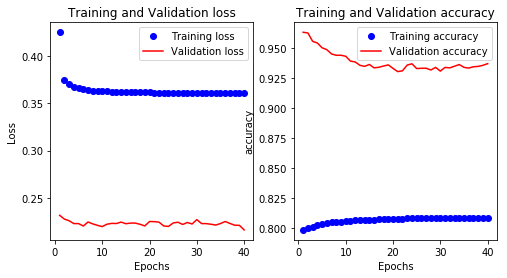

In [28]:
utils.plot_loss_and_accuracy(history)

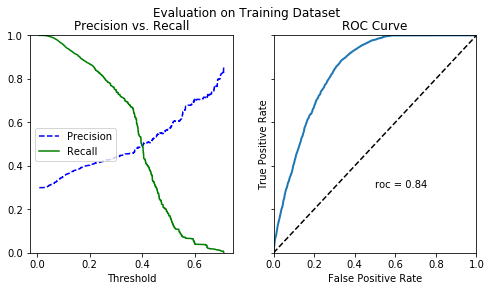

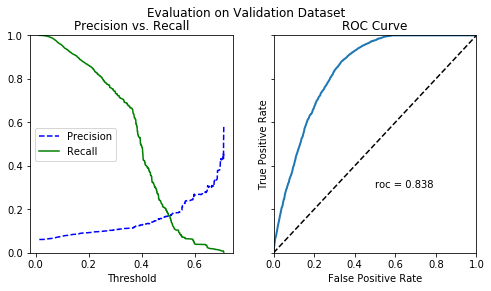

In [29]:
utils.evaluate_model(nn_cls, X_train, y_train, X_val, y_val, plot_train=True, model_type='keras')

## Pick XGBoost, and will fine-tune it

In [30]:
# will work on this.

## Make submission file

In [31]:
# utils.create_submission_file(xgb_cls, full_pipeline, filename='submit.csv')